# Data Science Nanodegree - Capstone Project: PySpark

## Customer Churn Prediction for the Sparkify Music Streaming Service

Head over to Medium to read my blogpost at

https://davidweisspost.medium.com/churn-prediction-with-pyspark-52ddece92ba4.

This is a Jupyter Notebook containing the code involving the dataset provided by Udacity.
Worked on IBM Cloud, a medium-sized version (248 MB, with 544,000 rows approximately) of the full dataset (12 GB) is uploaded to the IBM Cluster, for working with pyspark.

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

### Overview and the Problem Statement
This project deals with churn in a business setting, where the goal is to keep customers subscribed to a music streaming service. This specific dataset deals with data obtained from a hypothetical streaming service called Sparkify, made for Big Data Analysis using Apache Spark.

### The Business Need
Given a user's behavior on Sparkify, how likely are they to churn (to cancel their subscription)?
The question is solved through a Machine Learning classification approach.
The project explores different types of classification algorithms to support the argument that there is a strong partial correlation between the user's behavior and their likelihood to churn.
The algorithms trained and tested are: Random Forest Classifier, Logistic Regression.
The models are further tuned for its hyperparameters, to improve their performances, and the algorithms are evaluated based on the F1-Score.

### Evaluation
The Accuracy Score gives more importance to True Positives and True Negatives. This is good in cases of a balanced classification problem. The F1-Score on the other hand, by its very mathematical calculation, gives more importance to False Positives and False Negatives, and a higher F1-Score means better performance by the model.
Real world classification problems, especially for customer churn analysis, the data is often imbalanced (much more users do not churn, compared to users who churn).

Automated model selection by Grid Search and Cross Validation to tune the hyperparameters in order to obtain an optimal understanding of the interactions between the features and the target variable are also conducted in this project.

In [2]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as psqf
import pyspark.sql.types as psqt
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, max, min, lit, when, col, count, countDistinct , avg
from pyspark.sql.types import *

In [3]:
from sklearn.metrics import roc_curve, auc
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes ,LogisticRegression, RandomForestClassifier, DecisionTreeClassifier ,GBTClassifier
from pyspark.mllib.tree import DecisionTree
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import re
import seaborn as sns

In [5]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify capstone project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
path = "mini_sparkify_event_data.json"
sparkify_data = spark.read.json(path)

In [7]:
sparkify_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
sparkify_data.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [9]:
def show_null_columns(df):
    """
    Show number of null values per column of df
    """
    df.select([psqf.count(psqf.when(psqf.isnull(n), n)).alias(n) for n in df.columns]).show()

In [10]:
show_null_columns(sparkify_data)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [11]:
sparkify_data.filter(sparkify_data["userId"] == "").show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355841000|     null|      |
+------+----------+---------+------+----

In [12]:
def get_top_sorted_values(data, col, top):
    """
    Show the users in sorted order 
    """
    data.select([col]).dropDuplicates().sort(col).show(top)

In [13]:
# for col in sparkify_data.columns:
#     get_top_sorted_values(sparkify_data, col, 3)

### Columns with null values

- artist
- firstName
- lastName
- gender
- length
- location
- registration
- song
- userAgent
- userId ("")

In [14]:
sparkify_data = sparkify_data.filter(sparkify_data["userId"] != "")

In [15]:
# sparkify_data = sparkify_data.filter(sparkify_data["song"] != "null") # Events not related to playing music

In [16]:
show_null_columns(sparkify_data)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [54]:
sparkify_data.filter(sparkify_data["userId"] == 30).show(1)

+------+-----+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+
|userId|churn|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|
+------+-----+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+
|    30|    0|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|
+------+-----+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [18]:
sparkify_data.select("userId").distinct().count()

225

In [19]:
page_counts = sparkify_data.groupby('page').count()
page_counts.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [20]:
# define 1 as churned, 0 otherwise
hasChurned = psqf.udf(lambda x: 1 if 'Cancellation Confirmation' in set(x) else 0)

# Collect all page values and transform from "long" to "wide"-inline format
churn = sparkify_data.groupby('userId').agg(psqf.collect_list('page').alias('pages'))
churn = churn.withColumn("churn", hasChurned(churn.pages)).drop('pages')

In [21]:
churn.groupby("churn").count().withColumnRenamed('count', 'user_count').show()

+-----+----------+
|churn|user_count|
+-----+----------+
|    0|       173|
|    1|        52|
+-----+----------+



In [22]:
sparkify_data = churn.join(sparkify_data, "userId")

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [23]:
songs_played = sparkify_data.where(psqf.col('song')!='null').groupby("churn").agg(psqf.count(psqf.col('song')).alias('songs_played'))
songs_played.show()

+-----+------------+
|churn|songs_played|
+-----+------------+
|    0|      191714|
|    1|       36394|
+-----+------------+



In [24]:
songs_liked = sparkify_data.where((psqf.col('page')=='Thumbs Up')).groupby("churn").agg(psqf.count(psqf.col('page')).alias('songs_liked'))
songs_liked.show()

+-----+-----------+
|churn|songs_liked|
+-----+-----------+
|    0|      10692|
|    1|       1859|
+-----+-----------+



In [25]:
songs_not_liked = sparkify_data.where((psqf.col('page')=='Thumbs Down')).groupby("churn").agg(psqf.count(psqf.col('page')).alias('songs_not_liked'))
songs_not_liked.show()

+-----+---------------+
|churn|songs_not_liked|
+-----+---------------+
|    0|           2050|
|    1|            496|
+-----+---------------+



In [26]:
# See other features: Roll Advert, Add to Playlist, Add Friend, NextSong, Help, Error
# Compare relative values, divide by number of users who have churned / have not churned

In [27]:
df_to_plot = sparkify_data.groupby('userId', 'churn').count()
df_to_plot_pandas = df_to_plot.select("userId", 'churn').toPandas()

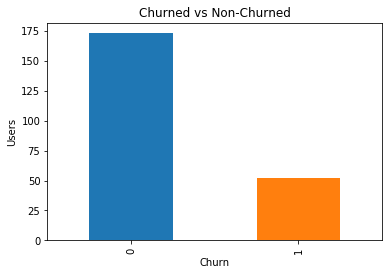

In [28]:
df_to_plot_pandas["churn"].value_counts().plot(kind='bar');
plt.ylabel('Users')
plt.xlabel('Churn')
plt.title('Churned vs Non-Churned');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [29]:
songs_played_count = sparkify_data.filter("page == 'NextSong'").groupBy("userId").count()
songs_played_count = songs_played_count.withColumnRenamed('count', 'songs_played')
songs_played_count.show(3)

+------+------------+
|userId|songs_played|
+------+------------+
|100010|         275|
|200002|         387|
|   125|           8|
+------+------------+
only showing top 3 rows



In [30]:
avg_title_length = sparkify_data.select(['userId', 'length']).distinct().groupBy("userId") \
.agg(avg("length").alias("avg_title_length")) # Unclear if "length" is the length of a session or a song
# avg_title_length.show(3)

In [31]:
songs_added_to_playlist = sparkify_data.where(sparkify_data.page=="Add to Playlist").groupby("userId").count()
songs_added_to_playlist = songs_added_to_playlist.withColumnRenamed('count', 'songs_added_to_playlist')
songs_added_to_playlist.show(3)

+------+-----------------------+
|userId|songs_added_to_playlist|
+------+-----------------------+
|100010|                      7|
|200002|                      8|
|   124|                    118|
+------+-----------------------+
only showing top 3 rows



In [32]:
like_counts = sparkify_data.where(sparkify_data.page=="Thumbs Up").groupby("userId").count()
like_counts = like_counts.withColumnRenamed('count', 'like_counts')
like_counts.show(3)

+------+-----------+
|userId|like_counts|
+------+-----------+
|100010|         17|
|200002|         21|
|   124|        171|
+------+-----------+
only showing top 3 rows



In [33]:
dislike_counts = sparkify_data.where(sparkify_data.page=="Thumbs Down").groupby("userId").count()
dislike_counts = dislike_counts.withColumnRenamed('count', 'dislike_counts')
dislike_counts.show(3)
# Maybe use a ratio --> liked / (liked + disliked)

+------+--------------+
|userId|dislike_counts|
+------+--------------+
|100010|             5|
|200002|             6|
|   124|            41|
+------+--------------+
only showing top 3 rows



In [34]:
songs_played_per_session = sparkify_data.where(sparkify_data.page=="NextSong").groupby("userId", "sessionId").count()
songs_played_per_session = songs_played_per_session.groupby("userId").agg(avg(songs_played_per_session["count"]).alias("songs_played_per_session"))
songs_played_per_session.show(3)

+------+------------------------+
|userId|songs_played_per_session|
+------+------------------------+
|100010|      39.285714285714285|
|200002|                    64.5|
|   125|                     8.0|
+------+------------------------+
only showing top 3 rows



In [36]:
users = churn
users = users.join(songs_played_count, on="userId", how="inner")
users = users.join(songs_played_per_session, on="userId", how="inner")
users = users.join(songs_added_to_playlist, on="userId", how="inner")
users = users.join(like_counts, on="userId", how="inner")
users = users.join(dislike_counts, on="userId", how="inner")
users.show(5)

+------+-----+------------+------------------------+-----------------------+-----------+--------------+
|userId|churn|songs_played|songs_played_per_session|songs_added_to_playlist|like_counts|dislike_counts|
+------+-----+------------+------------------------+-----------------------+-----------+--------------+
|100010|    0|         275|      39.285714285714285|                      7|         17|             5|
|200002|    0|         387|                    64.5|                      8|         21|             6|
|   124|    0|        4079|      145.67857142857142|                    118|        171|            41|
|    51|    1|        2111|                   211.1|                     52|        100|            21|
|     7|    0|         150|      21.428571428571427|                      5|          7|             1|
+------+-----+------------+------------------------+-----------------------+-----------+--------------+
only showing top 5 rows



In [37]:
def convert_to_float(dataset, col_names, new_type):
    for col_name in col_names:
        dataset = dataset.withColumn(col_name, dataset[col_name].cast(new_type))
    return dataset

In [38]:
convert_cols = users.columns[1:]
users = convert_to_float(users, convert_cols, FloatType())

In [39]:
users.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: float (nullable = true)
 |-- songs_played: float (nullable = false)
 |-- songs_played_per_session: float (nullable = true)
 |-- songs_added_to_playlist: float (nullable = false)
 |-- like_counts: float (nullable = false)
 |-- dislike_counts: float (nullable = false)



## Plot feature distribution

In [40]:
columns_to_plot = users.columns[1:]
plot_df = users.select(columns_to_plot).toPandas()

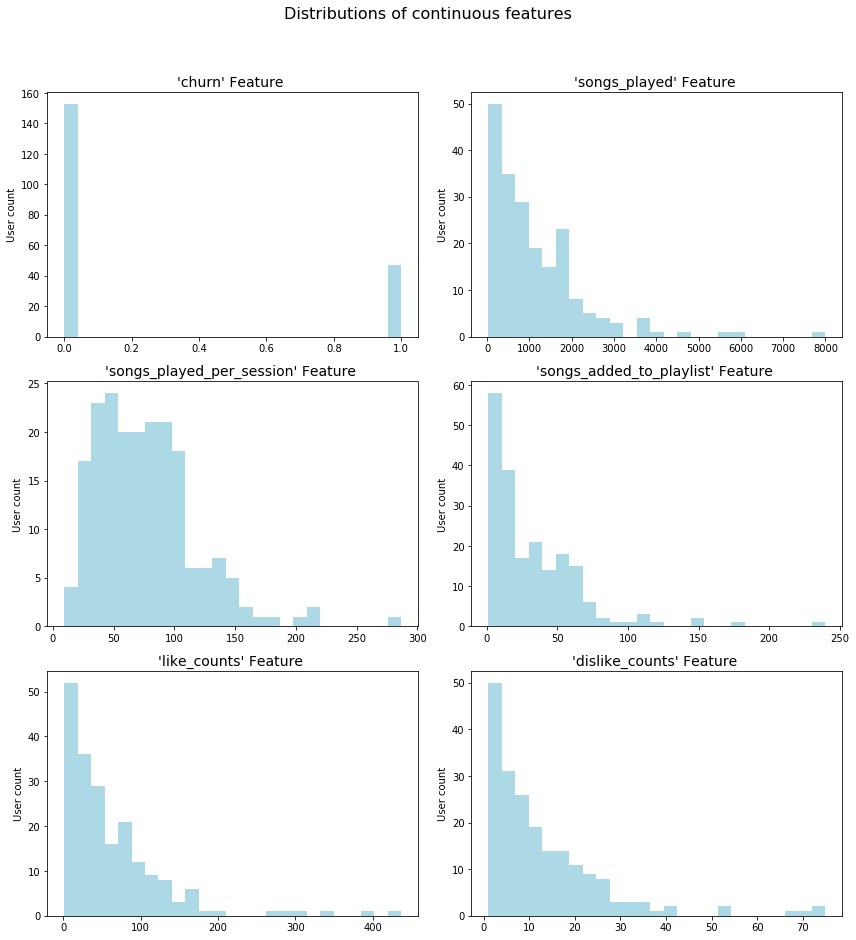

In [41]:
fig = plt.figure(figsize = (12, 16))

# Skewed feature plotting
for i, feature in enumerate(columns_to_plot):
    ax = fig.add_subplot(4, 2, i + 1)
    ax.hist(plot_df[feature], bins=25, color='lightblue')
    ax.set_title("'%s' Feature "%(feature), fontsize = 14)
    ax.set_ylabel("User count")

fig.suptitle("Distributions of continuous features", fontsize=16, y=1.05)
fig.tight_layout()

Most feature distributions are right skewed. Due to skewed data in our model, we will normalize the features in order to nullify the impact of larger values over smaller values.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Based on the Exploratory Data Analysis above, the features engineered and picked for modelling are defined below, along with the motivation for each feature.

In [42]:
features = [
    "songs_played",
    "songs_added_to_playlist",
    "like_counts",
    "dislike_counts",
    "songs_played_per_session",
]

In [43]:
# Assemble feature vector
assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
features_transformed = assembler.transform(users)

In [44]:
# Scale feature vector
scaler = StandardScaler(inputCol="features_vector", outputCol="features_scaled", withStd=True, withMean=False)
scaler_model = scaler.fit(features_transformed)
scaled_df = scaler_model.transform(features_transformed)

In [45]:
scaled_df.head(1)

[Row(userId='100010', churn=0.0, songs_played=275.0, songs_played_per_session=39.28571319580078, songs_added_to_playlist=7.0, like_counts=17.0, dislike_counts=5.0, features_vector=DenseVector([275.0, 7.0, 17.0, 5.0, 39.2857]), features_scaled=DenseVector([0.2463, 0.211, 0.2552, 0.3781, 0.9502]))]

In [46]:
df_rdy = scaled_df.withColumnRenamed("churn", "label") # Workaround for below: IllegalArgumentException: 'Field "label" does not exist

In [47]:
df_rdy = df_rdy.withColumnRenamed("features_scaled", "features")

In [48]:
df_rdy.head(1)

[Row(userId='100010', label=0.0, songs_played=275.0, songs_played_per_session=39.28571319580078, songs_added_to_playlist=7.0, like_counts=17.0, dislike_counts=5.0, features_vector=DenseVector([275.0, 7.0, 17.0, 5.0, 39.2857]), features=DenseVector([0.2463, 0.211, 0.2552, 0.3781, 0.9502]))]

In [49]:
# df_rdy.count() # 200 rows/users
# df_rdy = df_rdy.take(10)

### Model Selection & Evaluation

This part of the project includes the model selection - where the data is split into training and validation sets, and then passed on to the algorithms, which will train the data using cross validation, and then test it on the validation set.

In the final section of the project, where 2 different algorithms are trained, validated, tuned, and evaluated.
Based on the initial evaluations, the best model is picked for hyperparameter tuning.

#### Metrics

The training data is imbalanced with more samples in the not-churn class than in the churn class. Hence, we use the F1 score instead of accuracy as the evaluator.

We will train 2 algorithms on the dataset. The best model will then be selected for tuning.

* RandomForestClassifier
* LogisticRegression

In [50]:
train, test = df_rdy.randomSplit([0.8, 0.2], seed=42)

#### Random Forest

The Random Forest Classifier uses multiple Decision Tree Classifiers on different subsets of the data. The Random Forest Classifier's default state of Bootstrap being set to True, means that the decision trees will be used on subsets of the data, and then the metrics are averaged across all the decision trees.
Being one of the most popular algorithms for a Classification problem, the Random Forest Classifier works well in this particular problem as well, as it basically uses Decision Trees to analyze a binary outcome variable.
And as mentioned above, the F1-Score will be used to evaluate the model's performance, due to the imbalanced classes.

In [62]:
# The model is instantiated and fitted based on cross-validation, with F1 score as evaluation metric
rf = RandomForestClassifier(featuresCol='features_scaled', labelCol='label', seed=42, maxDepth=5)
f1_score = MulticlassClassificationEvaluator(metricName='f1')

paramGrid = ParamGridBuilder().build()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label')

crossValForest = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=10)

In [63]:
# The Cross-Validation RandomForestClassifier model is fitted to the training data
start = time.time()
cvForest = crossValForest.fit(train)
end = time.time()
print(f'Model trained in {end - start} seconds')
cvForest.avgMetrics

[0.6728877755948056]

In [67]:
# Getting the metrics for the performance of the model on the validation dataset
predForest = cvForest.transform(test)

print("The eval. metrics for Random Forest Classifier:")
print("F-1 Score {}".format(evaluator.evaluate(predForest, {evaluator.metricName : "accuracy"})))
print("Accuracy {}".format(evaluator.evaluate(predForest, {evaluator.metricName : "f1"})))

The eval. metrics for Random Forest Classifier:
F-1 Score 0.7419354838709677
Accuracy 0.6765591397849463


The Random Forest Classifier has obtained an F1-Score of 74.19%.

However, note that the accuracy is lower than the F1-Score, indicating an imbalanced dataset.

#### Logistic Regression

One of the simplest classification algorithms, the Logistic Regression is a binary classification algorithm, where the input features are used to estimate, probabilistically, the target variable.

In [70]:
# Instantiating the Logistic Regression model
logistic = LogisticRegression(featuresCol='features_scaled', labelCol='label', maxIter=50)

# The model is fitted with cross validation on the training data
crossValLog = CrossValidator(estimator=logistic, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=3)
cvLog = crossValLog.fit(train)
cvLog.avgMetrics

[0.6809507340131279]

In [72]:
# Making predictions on the Validation data for Logistic Regression.
predLog = cvLog.transform(test)

print("The eval. metrics for Logistic Regression: ")
print("F-1 Score: {}".format(evaluator.evaluate(predLog, {evaluator.metricName : "accuracy"})))
print("Accuracy: {}".format(evaluator.evaluate(predLog, {evaluator.metricName : "f1"})))

The eval. metrics for Logistic Regression: 
F-1 Score: 0.6774193548387096
Accuracy: 0.5471464019851118


### Model Tuning

#### Random Forest - Tuning

The maxDepth and numTrees parameters of the Random Forest model will be tuned.

* maxDepth is the depth of each decision tree in the ensemble. The deeper the trees, the more information is collected to make a classification, but could also lead to overfitting.

* numTrees is the total number of decision trees to run in the ensemble. The default value is 20.

In [51]:
forest_grid = RandomForestClassifier(seed=42)
paramGridForest = ParamGridBuilder().addGrid(forest_grid.maxDepth, [5, 10]).\
                                     addGrid(forest_grid.numTrees, [20, 10]).build()
f1_evaluation = MulticlassClassificationEvaluator(metricName='f1')
crossValForestGrid = CrossValidator(estimator=forest_grid, estimatorParamMaps=paramGridForest, evaluator=f1_evaluation, numFolds=10)
cvforest = crossValForestGrid.fit(train)
cvforest.avgMetrics

[0.6934161545932176,
 0.7047776346691189,
 0.7205750736727716,
 0.7384471386544124]

In [53]:
predictions = cvforest.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The final metrics for the tuned RandomForest Classifier: ")
print("The F-1 Score is {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "f1"})))

The final metrics for the tuned RandomForest Classifier: 
The F-1 Score is 0.7741935483870968
The accuracy is 0.7485701212537176


## Conclusion

The hyperparameter tuning with grid search did improve the Random Forest Classifier Model by 3.8% to an overall F1 score of **77.41%**.

Compared to the Logistic Regression Model with a 67.74% score, the Random Forest Model is recommended in terms of scaling the algorithm to the large 12 GB dataset.

The quality of the model is **limited by the number of unique users** in the dataset. In combination with the **class imbalance**, the small dataset size can lead to overestimated metrics. A possible solution approach is undersampling the majority class (churn == 0). On the one hand, this can lead to more unbiased estimates, while there are drawbacks on the other hand, such as not enough observations (in this case users) to train the models.

## Outlook

Possible improvements are

* Trying other models such as
    * GradientBoostedTreeClassifier
    * Naive Bayes classifier
    * DecisionTreeClassifier
* Further feature engineering
    * Relative features, e.g. (likes / (likes + dislikes))
* Extensive model tuning
    * More training time
    * Larger grid search parameter ranges